## Importing Packages

In [5]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [6]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
#     w1 = 90000.0
#     w2 = 10000.0
#     w3 = 100000.0 
#     w4 = 200000.0
#     w5 = 300000.0
#     w6 = 400000.0
#     w7 = 500000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 1e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end


# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end


ice_viscosity (generic function with 1 method)

# Material Setup

In [7]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

In [8]:
# function run(nstep::Int64)
#     nstep=50
    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3

    
#     Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbctype = [1,-1,1,1]
#     Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    max_time::Float64=2.5e10
    max_step::Int64=-1
    max_time::Float64 = max_time == 2.5e10 ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step



    # Setting up inital model schematic
    i_air_ice_interface = zeros(Float64,grid.nx+1)
    i_ocean_ice_interface = zeros(Float64,grid.nx+1)
    # Transfer materials to nodes
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    function get_i_interface(grid::CartesianGrid,mat,contour_value)
        i_interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
            i = 1
            while i <= grid.ny
                if i_mat[i,j] == contour_value
                    i_interface_position[j] = grid.yc[j]
                    break
                elseif i_mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                    break
                end
                i = i+1
            end
        end
        return i_interface_position
    end
    i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)


    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    
    time = 0.0
    iout=0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    eta_s = nothing
    Hr = nothing
    Cp_c = nothing
    alpha = nothing
    eta_n = nothing
    Tlast = nothing
    rho_vx = nothing 
    rho_vy = nothing
    vxc = nothing 
    vyc = nothing
    dTmax = nothing
    T = nothing 

#     local rho_c 
#     local rho_vx
#     local rho_vy
#     local alpha
#     local Hr
#     local Cp_c
#     local eta_s
#     local eta_n
#     local vxc
#     local vyc
#     local T
#     local dt
#     local dTmax
#     local dTemp
#     local Tnew
#     local Tlast

    itime = 1

    terminate = false
    while !terminate
    output_dir = "test"
#     for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 
       
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
   
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
#             dTmax = maximum(abs.(dTemp))
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            
#             println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
        # Checking Termination Criteria, time is in seconds
        if time >= max_time || itime >= max_step
            terminate = true
        end    

        if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
    
#         println("Min velocity: "," ",minimum(vyc))
#         println("Max velocity: "," ",maximum(vyc))
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
#         println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
        println("Finished Step ",itime," time=",time," Seconds")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
# end 
# @time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.086513 seconds (74.51 k allocations: 37.551 MiB, 88.44% compilation time)
Initial condition...
  0.094759 seconds (1.72 M allocations: 27.869 MiB)
Trying with timestep 1.2968471615380294e9
Trying with timestep 8.268800778285594e7
  0.003401 seconds (2 allocations: 5.493 MiB)
Finished Step 2 time=5.311089769813211e6 Seconds
Trying with timestep 6.3733077237758525e6
Trying with timestep 3.9020994077983564e6
Finished Step 3 time=7.732846866198268e6 Seconds
Trying with timestep 2.906108515662068e6
Finished Step 4 time=1.0638955381860336e7 Seconds
Trying with timestep 3.4873302187944814e6
Finished Step 5 time=1.4126285600654818e7 Seconds
Trying with timestep 4.1847962625533775e6
Finished Step 6 time=1.8311081863208197e7 Seconds
Trying with timestep 5.021755515064053e6
Finished Step 7 time=2.333283737827225e7 Seconds
Trying with timestep 6.026106618076864e6
Finished Step 8 time=2.9358943996349115e7 Seconds
Trying with timestep 7.231327941692236e6
Finished Step 9 time=

Trying with timestep 6.025710780521149e9
Finished Step 88 time=1.6828244706001743e11 Seconds
Trying with timestep 6.21595745062795e9
Finished Step 89 time=1.744984045106454e11 Seconds
Trying with timestep 6.407518209912987e9
Finished Step 90 time=1.8090592272055838e11 Seconds
Trying with timestep 6.597002856506379e9
Finished Step 91 time=1.8750292557706476e11 Seconds
Trying with timestep 6.795215464008248e9
Finished Step 92 time=1.94298141041073e11 Seconds
Trying with timestep 6.998307744061154e9
Finished Step 93 time=2.0129644878513416e11 Seconds
Trying with timestep 7.228261523516654e9
Finished Step 94 time=2.0852471030865082e11 Seconds
Trying with timestep 7.444467965826079e9
Finished Step 95 time=2.159691782744769e11 Seconds
Trying with timestep 7.666880275040001e9
Finished Step 96 time=2.236360585495169e11 Seconds
Trying with timestep 7.897355210677813e9
Finished Step 97 time=2.3153341376019473e11 Seconds
Trying with timestep 8.117966589459618e9
Finished Step 98 time=2.39651380349

Trying with timestep 76852.8562596973
Finished Step 164 time=3.345963058224549e11 Seconds
Trying with timestep 92223.42751163676
Finished Step 165 time=3.345963980458824e11 Seconds
Trying with timestep 110668.11301396412
Finished Step 166 time=3.345965087139954e11 Seconds
Trying with timestep 132801.73561675692
Finished Step 167 time=3.34596641515731e11 Seconds
Trying with timestep 159362.0827401083
Finished Step 168 time=3.345968008778138e11 Seconds
Trying with timestep 191234.49928812997
Finished Step 169 time=3.3459699211231305e11 Seconds
Trying with timestep 229481.39914575595
Finished Step 170 time=3.345972215937122e11 Seconds
Trying with timestep 275377.67897490715
Finished Step 171 time=3.345974969713912e11 Seconds
Trying with timestep 330453.21476988855
Finished Step 172 time=3.3459782742460596e11 Seconds
Trying with timestep 396543.85772386624
Finished Step 173 time=3.345982239684637e11 Seconds
Trying with timestep 475852.6292686395
Finished Step 174 time=3.3459869982109296e11

Trying with timestep 60511.69004695955
Finished Step 249 time=3.3466483240255035e11 Seconds
Trying with timestep 72614.02805635145
Finished Step 250 time=3.346649050165784e11 Seconds
Trying with timestep 87136.83366762174
Finished Step 251 time=3.346649921534121e11 Seconds
Trying with timestep 104564.2004011461
Finished Step 252 time=3.346650967176125e11 Seconds
Trying with timestep 125477.04048137531
Finished Step 253 time=3.3466522219465295e11 Seconds
Trying with timestep 150572.44857765036
Finished Step 254 time=3.346653727671015e11 Seconds
Trying with timestep 180686.93829318043
Finished Step 255 time=3.346655534540398e11 Seconds
Trying with timestep 216824.3259518165
Finished Step 256 time=3.346657702783657e11 Seconds
Trying with timestep 260189.1911421798
Finished Step 257 time=3.346660304675569e11 Seconds
Trying with timestep 312227.0293706157
Finished Step 258 time=3.3466634269458624e11 Seconds
Trying with timestep 374672.4352447389
Finished Step 259 time=3.346667173670215e11 S

Trying with timestep 527606.4998394727
Finished Step 334 time=3.3468311114909515e11 Seconds
Trying with timestep 633127.7998073673
Finished Step 335 time=3.3468374427689496e11 Seconds
Trying with timestep 759753.3597688407
Finished Step 336 time=3.346845040302547e11 Seconds
Trying with timestep 911704.0317226088
Trying with timestep 783517.0016207332
Finished Step 337 time=3.346851989784027e11 Seconds
Trying with timestep 833937.7775853266
Trying with timestep 138695.9408399167
Finished Step 338 time=3.34685242084891e11 Seconds
Trying with timestep 51727.78595250156
Trying with timestep 22736.891344371466
Finished Step 339 time=3.346852607798679e11 Seconds
Trying with timestep 22433.972346712733
Finished Step 340 time=3.346852832138403e11 Seconds
Trying with timestep 26920.76681605528
Finished Step 341 time=3.346853101346071e11 Seconds
Trying with timestep 32304.920179266333
Finished Step 342 time=3.346853424395273e11 Seconds
Trying with timestep 38765.9042151196
Finished Step 343 time

Finished Step 417 time=3.346998070686522e11 Seconds
Trying with timestep 132812.05669213037
Finished Step 418 time=3.346999398807089e11 Seconds
Trying with timestep 159374.46803055643
Finished Step 419 time=3.3470009925517694e11 Seconds
Trying with timestep 191249.36163666772
Finished Step 420 time=3.347002905045386e11 Seconds
Trying with timestep 229499.23396400127
Finished Step 421 time=3.347005200037725e11 Seconds
Trying with timestep 275399.08075680153
Finished Step 422 time=3.347007954028533e11 Seconds
Trying with timestep 330478.8969081618
Finished Step 423 time=3.347011258817502e11 Seconds
Trying with timestep 396574.67628979415
Finished Step 424 time=3.3470152245642645e11 Seconds
Trying with timestep 475889.611547753
Finished Step 425 time=3.34701998346038e11 Seconds
Trying with timestep 571067.5338573036
Finished Step 426 time=3.347025694135719e11 Seconds
Trying with timestep 685281.0406287642
Finished Step 427 time=3.3470325469461255e11 Seconds
Trying with timestep 822337.248

  0.003169 seconds (2 allocations: 5.493 MiB)
Finished Step 501 time=3.347318913104237e11 Seconds
Trying with timestep 1.9468344639384174e6
Finished Step 502 time=3.3473383814488763e11 Seconds
Trying with timestep 2.3362013567261007e6
Finished Step 503 time=3.347361743462444e11 Seconds
Trying with timestep 2.8034416280713207e6
Finished Step 504 time=3.3473897778787244e11 Seconds
Trying with timestep 3.364129953685585e6
Finished Step 505 time=3.347423419178261e11 Seconds
Trying with timestep 4.036955944422702e6
Finished Step 506 time=3.347463788737705e11 Seconds
Trying with timestep 4.844347133307242e6
Finished Step 507 time=3.347512232209038e11 Seconds
Trying with timestep 5.81321655996869e6
Finished Step 508 time=3.347570364374638e11 Seconds
Trying with timestep 6.975859871962428e6
Finished Step 509 time=3.3476401229733575e11 Seconds
Trying with timestep 8.371031846354913e6
Finished Step 510 time=3.347723833291821e11 Seconds
Trying with timestep 1.0045238215625895e7
Finished Step 511 

Trying with timestep 1.3083879432627487e10
Finished Step 587 time=4.2300211071230994e11 Seconds
Trying with timestep 1.6676796709826818e9
Trying with timestep 898343.6318479823
Finished Step 588 time=4.2300211474624243e11 Seconds
Trying with timestep 4840.719016251981
Trying with timestep 1463.65632601186
Finished Step 589 time=4.230021161684335e11 Seconds
Trying with timestep 1706.6292747385535
Trying with timestep 1649.2612969306183
Finished Step 590 time=4.2300211781689825e11 Seconds
Trying with timestep 1978.1577586561853
Trying with timestep 1103.2457787930728
Finished Step 591 time=4.2300211890902356e11 Seconds
Trying with timestep 1310.5503301316924
Trying with timestep 439.3084425294118
Finished Step 592 time=4.2300211934416473e11 Seconds
Trying with timestep 522.169404320125
Finished Step 593 time=4.2300211986633417e11 Seconds
Trying with timestep 626.60328518415
Finished Step 594 time=4.2300212049293744e11 Seconds
Trying with timestep 751.9239422209799
Finished Step 595 time=

Trying with timestep 3164.6770175868787
Trying with timestep 2690.786763888345
Finished Step 651 time=4.230022250404576e11 Seconds
Trying with timestep 3217.874038991055
Trying with timestep 2736.6255416571366
Finished Step 652 time=4.2300222776760547e11 Seconds
Trying with timestep 3272.577454753897
Trying with timestep 2783.7767151839685
Finished Step 653 time=4.230022305416424e11 Seconds
Trying with timestep 3328.8443061824237
Trying with timestep 2832.2904378853823
Finished Step 654 time=4.230022333639209e11 Seconds
Trying with timestep 3386.7342367473943
Trying with timestep 2882.2191681198415
Finished Step 655 time=4.230022362358456e11 Seconds
Trying with timestep 3446.3096254483307
Trying with timestep 2933.6177879437005
Finished Step 656 time=4.2300223915887537e11 Seconds
Trying with timestep 3507.635727343539
Trying with timestep 2986.543728347113
Finished Step 657 time=4.2300224213452606e11 Seconds
Trying with timestep 3570.780821715788
Trying with timestep 3041.0571012265777

Finished Step 713 time=4.2300256476835944e11 Seconds
Trying with timestep 12546.767232414268
Trying with timestep 10826.647090328352
Finished Step 714 time=4.230025755471589e11 Seconds
Trying with timestep 12934.559331848584
Trying with timestep 11167.581734762782
Finished Step 715 time=4.2300258666501447e11 Seconds
Trying with timestep 13341.426680156052
Trying with timestep 11525.552155387713
Finished Step 716 time=4.230025981388632e11 Seconds
Trying with timestep 13768.61849678265
Trying with timestep 11901.691689444127
Finished Step 717 time=4.230026099867687e11 Seconds
Trying with timestep 14217.48654274173
Trying with timestep 12297.22842667842
Finished Step 718 time=4.230026222280149e11 Seconds
Trying with timestep 14689.495481421343
Trying with timestep 12713.49500465228
Finished Step 719 time=4.230026348832103e11 Seconds
Trying with timestep 15186.234524491161
Trying with timestep 13151.9396531181
Finished Step 720 time=4.2300264797440247e11 Seconds
Trying with timestep 15709.

Finished Step 779 time=4.230156083904366e11 Seconds
Trying with timestep 23871.37503392266
Trying with timestep 18586.55677562212
Finished Step 780 time=4.230156262175076e11 Seconds
Trying with timestep 21392.48521993827
Trying with timestep 17007.12161159382
Finished Step 781 time=4.230156426341538e11 Seconds
Trying with timestep 19699.97540419683
Trying with timestep 15922.754528708487
Finished Step 782 time=4.230156580728827e11 Seconds
Trying with timestep 18526.47466890058
Trying with timestep 15366.913267802149
Finished Step 783 time=4.230156730446753e11 Seconds
Trying with timestep 17966.15109665268
Trying with timestep 15119.922659891554
Finished Step 784 time=4.2301568781264136e11 Seconds
Trying with timestep 17721.559256362056
Trying with timestep 15080.016569605456
Finished Step 785 time=4.230157025662891e11 Seconds
Trying with timestep 17704.377315131773
Trying with timestep 15240.23470896219
Finished Step 786 time=4.230157174989909e11 Seconds
Trying with timestep 17919.2421

Trying with timestep 3.54283407550546e6
Trying with timestep 2.2008195408834554e6
Finished Step 858 time=4.231838887983234e11 Seconds
Trying with timestep 1.6953357572103578e6
Trying with timestep 1.2253919215454073e6
Finished Step 859 time=4.231848044371577e11 Seconds
Trying with timestep 1.0987666011508303e6
Trying with timestep 849253.9295923667
Finished Step 860 time=4.231854833431579e11 Seconds
Trying with timestep 814687.2002052392
Trying with timestep 647577.3905294037
Finished Step 861 time=4.231860169191335e11 Seconds
Trying with timestep 640291.1706864849
Trying with timestep 515644.57951286837
Finished Step 862 time=4.2318644883707416e11 Seconds
Trying with timestep 518301.5288127276
Trying with timestep 420517.7745608794
Finished Step 863 time=4.231868051268374e11 Seconds
Trying with timestep 427547.71589428996
Trying with timestep 348783.6226040103
Finished Step 864 time=4.2318710351388934e11 Seconds
Trying with timestep 358064.4623648949
Trying with timestep 293599.963009

Trying with timestep 17164.15714680427
Trying with timestep 14085.782712357104
Finished Step 920 time=4.2319069223083813e11 Seconds
Trying with timestep 16425.48692720384
Trying with timestep 13460.370219425105
Finished Step 921 time=4.231907053224853e11 Seconds
Trying with timestep 15709.976602755884
Trying with timestep 12856.468333700306
Finished Step 922 time=4.231907178377828e11 Seconds
Trying with timestep 15018.356994752163
Trying with timestep 12274.426544133474
Finished Step 923 time=4.2319072979698157e11 Seconds
Trying with timestep 14351.038535974008
Trying with timestep 11714.360560558265
Finished Step 924 time=4.23190741220464e11 Seconds
Trying with timestep 13708.178932751884
Trying with timestep 11176.202885960365
Finished Step 925 time=4.231907521285781e11 Seconds
Trying with timestep 13089.736963960915
Trying with timestep 10659.741873745668
Finished Step 926 time=4.231907625415063e11 Seconds
Trying with timestep 12495.513786332309
Trying with timestep 10164.6530501978

Finished Step 982 time=4.231909645944663e11 Seconds
Trying with timestep 1038.9507559083997
Trying with timestep 835.3973150808612
Finished Step 983 time=4.231909654280548e11 Seconds
Trying with timestep 1000.3061976216914
Trying with timestep 804.467269998784
Finished Step 984 time=4.2319096623084564e11 Seconds
Trying with timestep 963.3489662245531
Trying with timestep 774.8892619200848
Finished Step 985 time=4.2319096700418036e11 Seconds
Trying with timestep 928.0016613171135
Trying with timestep 746.9992841644762
Finished Step 986 time=4.2319096774973987e11 Seconds
Trying with timestep 894.6713830712752
Trying with timestep 720.2847870038605
Finished Step 987 time=4.2319096846868665e11 Seconds
Trying with timestep 862.7361359238263
Trying with timestep 694.6866604975655
Finished Step 988 time=4.2319096916212933e11 Seconds
Trying with timestep 832.13124146035
Trying with timestep 670.1530406135664
Finished Step 989 time=4.2319096983112537e11 Seconds
Trying with timestep 802.79521184

Finished Step 1044 time=4.231909866916134e11 Seconds
Trying with timestep 151.9178153622004
Trying with timestep 123.44697547488103
Finished Step 1045 time=4.231909868150226e11 Seconds
Trying with timestep 148.09103730971864
Trying with timestep 120.35333650170982
Finished Step 1046 time=4.2319098693534e11 Seconds
Trying with timestep 144.38094177293485
Trying with timestep 117.35358638483042
Finished Step 1047 time=4.2319098705265955e11 Seconds
Trying with timestep 140.78338750159654
Trying with timestep 114.4444027139588
Finished Step 1048 time=4.2319098716707153e11 Seconds
Trying with timestep 137.29439513299982
Trying with timestep 111.62260187966172
Finished Step 1049 time=4.231909872786633e11 Seconds
Trying with timestep 133.91015139070237
Trying with timestep 108.88512363624766
Finished Step 1050 time=4.2319098738751917e11 Seconds
Trying with timestep 130.62699056557506
Trying with timestep 106.22902497196038
Finished Step 1051 time=4.2319098749372034e11 Seconds
Trying with time

Finished Step 1106 time=4.231909907938961e11 Seconds
Trying with timestep 39.01244262070593
Trying with timestep 31.90571794736991
Finished Step 1107 time=4.231909908257994e11 Seconds
Trying with timestep 38.28392959645737
Trying with timestep 31.312394466488584
Finished Step 1108 time=4.2319099085710944e11 Seconds
Trying with timestep 37.5720506168169
Trying with timestep 30.732563076888752
Finished Step 1109 time=4.231909908878397e11 Seconds
Trying with timestep 36.87635763665334
Trying with timestep 30.165862555457483
Finished Step 1110 time=4.231909909180034e11 Seconds
Trying with timestep 36.196417392817004
Trying with timestep 29.61194299543376
Finished Step 1111 time=4.231909909476133e11 Seconds
Trying with timestep 35.53181019139098
Trying with timestep 29.070463312017726
Finished Step 1112 time=4.231909909766817e11 Seconds
Trying with timestep 34.88212691464978
Trying with timestep 28.54109665476385
Finished Step 1113 time=4.231909910052208e11 Seconds
Trying with timestep 34.2

Finished Step 1168 time=4.2319099201254315e11 Seconds
Trying with timestep 13.823180594742274
Trying with timestep 11.349689576587124
Finished Step 1169 time=4.231909920238925e11 Seconds
Trying with timestep 13.61926416518443
Trying with timestep 11.182824823178501
Finished Step 1170 time=4.231909920350751e11 Seconds
Trying with timestep 13.419037162072874
Trying with timestep 11.018969011694582
Finished Step 1171 time=4.2319099204609375e11 Seconds
Trying with timestep 13.222420538983313
Trying with timestep 10.858057887467933
Finished Step 1172 time=4.2319099205695154e11 Seconds
Trying with timestep 13.029337202926618
Trying with timestep 10.70002842486867
Finished Step 1173 time=4.231909920676513e11 Seconds
Trying with timestep 12.839711535222897
Trying with timestep 10.544819769582327
Finished Step 1174 time=4.2319099207819586e11 Seconds
Trying with timestep 12.653470522425266
Trying with timestep 10.392372859812317
Finished Step 1175 time=4.2319099208858795e11 Seconds
Trying with t

Finished Step 1230 time=4.231909924867106e11 Seconds
Trying with timestep 5.986197298126182
Trying with timestep 4.927756786796717
Finished Step 1231 time=4.2319099249163824e11 Seconds
Trying with timestep 5.913240615628497
Trying with timestep 4.867866397599285
Finished Step 1232 time=4.2319099249650604e11 Seconds
Trying with timestep 5.841373792530832
Trying with timestep 4.808867839067345
Finished Step 1233 time=4.231909925013149e11 Seconds
Trying with timestep 5.7705771217352355
Trying with timestep 4.750745763439766
Finished Step 1234 time=4.2319099250606555e11 Seconds
Trying with timestep 5.700832187298636
Trying with timestep 4.693484254569493
Finished Step 1235 time=4.23190992510759e11 Seconds
Trying with timestep 5.632119891071981
Trying with timestep 4.637068399184084
Finished Step 1236 time=4.23190992515396e11 Seconds
Trying with timestep 5.564422338413964
Trying with timestep 4.581483637222494
Finished Step 1237 time=4.231909925199774e11 Seconds
Trying with timestep 5.49772

Trying with timestep 2.966331063059205
Trying with timestep 2.4462344312536524
Finished Step 1293 time=4.2319099270807056e11 Seconds
Trying with timestep 2.935464842013492
Trying with timestep 2.4208387642147566
Finished Step 1294 time=4.231909927104914e11 Seconds
Trying with timestep 2.9049903840668563
Trying with timestep 2.3957650107402397
Finished Step 1295 time=4.2319099271288715e11 Seconds
Trying with timestep 2.8749022145116165
Trying with timestep 2.3710084727856025
Finished Step 1296 time=4.231909927152581e11 Seconds
Trying with timestep 2.84519469588437
Trying with timestep 2.3465638736526646
Finished Step 1297 time=4.231909927176047e11 Seconds
Trying with timestep 2.815861496324603
Trying with timestep 2.3224271468734208
Finished Step 1298 time=4.2319099271992706e11 Seconds
Trying with timestep 2.786897736293603
Trying with timestep 2.2985934107262302
Finished Step 1299 time=4.2319099272222565e11 Seconds
Trying with timestep 2.7582975578805615
Trying with timestep 2.27505795

Finished Step 1354 time=4.2319099281919745e11 Seconds
Trying with timestep 1.617152271678232
Trying with timestep 1.3353501995806265
Finished Step 1355 time=4.231909928205328e11 Seconds
Trying with timestep 1.6024153659734197
Trying with timestep 1.3232050124818926
Finished Step 1356 time=4.2319099282185596e11 Seconds
Trying with timestep 1.5878412301876734
Trying with timestep 1.3111938582975569
Finished Step 1357 time=4.231909928231672e11 Seconds
Trying with timestep 1.5734279321162177
Trying with timestep 1.2993149867866793
Finished Step 1358 time=4.231909928244665e11 Seconds
Trying with timestep 1.559173371505578
Trying with timestep 1.2875663644761373
Finished Step 1359 time=4.23190992825754e11 Seconds
Trying with timestep 1.5450751082226974
Trying with timestep 1.2759466675275042
Finished Step 1360 time=4.2319099282702997e11 Seconds
Trying with timestep 1.5311315537102075
Trying with timestep 1.2644540959687443
Finished Step 1361 time=4.2319099282829443e11 Seconds
Trying with tim

Trying with timestep 0.9535151169753647
Trying with timestep 0.7881129204151162
Finished Step 1416 time=4.231909928832588e11 Seconds
Trying with timestep 0.9457338161495374
Trying with timestep 0.7816921716896917
Finished Step 1417 time=4.2319099288404047e11 Seconds
Trying with timestep 0.9380289452073169
Trying with timestep 0.7753343257740093
Finished Step 1418 time=4.231909928848158e11 Seconds
Trying with timestep 0.9303995571421695
Trying with timestep 0.7690385432447425
Finished Step 1419 time=4.2319099288558484e11 Seconds
Trying with timestep 0.9228446446556242
Trying with timestep 0.7628041001392238
Finished Step 1420 time=4.2319099288634766e11 Seconds
Trying with timestep 0.9153633390030993
Trying with timestep 0.7566305275139786
Finished Step 1421 time=4.231909928871043e11 Seconds
Trying with timestep 0.9079550774638083
Trying with timestep 0.750516901306978
Finished Step 1422 time=4.231909928878548e11 Seconds
Trying with timestep 0.9006187511678245
Trying with timestep 0.7444

Finished Step 1477 time=4.2319099292121765e11 Seconds
Trying with timestep 0.5874861995094585
Trying with timestep 0.48593873360319295
Finished Step 1478 time=4.231909929217036e11 Seconds
Trying with timestep 0.5831258411744442
Trying with timestep 0.4823369498548509
Finished Step 1479 time=4.23190992922186e11 Seconds
Trying with timestep 0.5788037101526083
Trying with timestep 0.47876703467368736
Finished Step 1480 time=4.2319099292266473e11 Seconds
Trying with timestep 0.5745198212598734
Trying with timestep 0.4752283729024934
Finished Step 1481 time=4.2319099292313995e11 Seconds
Trying with timestep 0.5702734363063561
Trying with timestep 0.47172081088524853
Finished Step 1482 time=4.231909929236117e11 Seconds
Trying with timestep 0.5660643709104196
Trying with timestep 0.46824385290191317
Finished Step 1483 time=4.2319099292407996e11 Seconds
Trying with timestep 0.5618920302086224
Trying with timestep 0.464797305504554
Finished Step 1484 time=4.2319099292454474e11 Seconds
Trying wi

Finished Step 1538 time=4.2319099294525793e11 Seconds
Trying with timestep 0.3795664658205444
Trying with timestep 0.3141345124557157
Finished Step 1539 time=4.231909929455721e11 Seconds
Trying with timestep 0.3769611487083578
Trying with timestep 0.31198082280577566
Finished Step 1540 time=4.2319099294588403e11 Seconds
Trying with timestep 0.3743767247786894
Trying with timestep 0.3098444167637019
Finished Step 1541 time=4.2319099294619385e11 Seconds
Trying with timestep 0.37181304112431096
Trying with timestep 0.3077251573372082
Finished Step 1542 time=4.231909929465016e11 Seconds
Trying with timestep 0.3692699333553115
Trying with timestep 0.3056227403740732
Finished Step 1543 time=4.231909929468072e11 Seconds
Trying with timestep 0.3667470364892503
Trying with timestep 0.3035371246907076
Finished Step 1544 time=4.231909929471107e11 Seconds
Trying with timestep 0.36424430110773975
Trying with timestep 0.301468075774391
Finished Step 1545 time=4.231909929474122e11 Seconds
Trying with

Trying with timestep 0.2527562466226584
Trying with timestep 0.20927476066903933
Finished Step 1600 time=4.231909929612334e11 Seconds
Trying with timestep 0.25112959493457393
Trying with timestep 0.20792929706540264
  0.003211 seconds (2 allocations: 5.493 MiB)
Finished Step 1601 time=4.2319099296144135e11 Seconds
Trying with timestep 0.24951504012534723
Trying with timestep 0.20659363215737928
Finished Step 1602 time=4.2319099296164795e11 Seconds
Trying with timestep 0.2479122437293848
Trying with timestep 0.2052678819662684
Finished Step 1603 time=4.231909929618532e11 Seconds
Trying with timestep 0.2463213449737302
Trying with timestep 0.2039518540393023
Finished Step 1604 time=4.231909929620572e11 Seconds
Trying with timestep 0.24474211291441147
Trying with timestep 0.20264543545768146
Finished Step 1605 time=4.231909929622598e11 Seconds
Trying with timestep 0.24317441204956702
Trying with timestep 0.20134863350368004
Finished Step 1606 time=4.231909929624612e11 Seconds
Trying with 

Finished Step 1660 time=4.231909929716442e11 Seconds
Trying with timestep 0.17222609402302289
Trying with timestep 0.14264434246409943
Finished Step 1661 time=4.2319099297178687e11 Seconds
Trying with timestep 0.17117315629783744
Trying with timestep 0.1417728805647597
Finished Step 1662 time=4.2319099297192865e11 Seconds
Trying with timestep 0.17012740268583312
Trying with timestep 0.14090742104235623
Finished Step 1663 time=4.231909929720696e11 Seconds
Trying with timestep 0.16908885191763035
Trying with timestep 0.1400478411536066
Finished Step 1664 time=4.2319099297220966e11 Seconds
Trying with timestep 0.1680573567011124
Trying with timestep 0.13919406797381023
Finished Step 1665 time=4.231909929723489e11 Seconds
Trying with timestep 0.16703282952694926
Trying with timestep 0.1383462191057375
Finished Step 1666 time=4.2319099297248724e11 Seconds
Trying with timestep 0.1660154115188653
Trying with timestep 0.13750406207959895
Finished Step 1667 time=4.2319099297262476e11 Seconds
Tr

Trying with timestep 0.12006298841879653
Trying with timestep 0.09946349433873863
Finished Step 1721 time=4.231909929789429e11 Seconds
Trying with timestep 0.11935616666588525
Trying with timestep 0.09887830060942893
Finished Step 1722 time=4.2319099297904175e11 Seconds
Trying with timestep 0.11865393450264075
Trying with timestep 0.0982968283824108
Finished Step 1723 time=4.2319099297914e11 Seconds
Trying with timestep 0.11795616813822672
Trying with timestep 0.0977190523226353
Finished Step 1724 time=4.2319099297923773e11 Seconds
Trying with timestep 0.11726283717073457
Trying with timestep 0.09714499131801795
Finished Step 1725 time=4.231909929793349e11 Seconds
Trying with timestep 0.11657396426574568
Trying with timestep 0.09657456871559221
Finished Step 1726 time=4.2319099297943146e11 Seconds
Trying with timestep 0.11588945743967985
Trying with timestep 0.09600783536812833
Finished Step 1727 time=4.2319099297952747e11 Seconds
Trying with timestep 0.11520937771600831
Trying with ti

Trying with timestep 0.08415979842081689
Trying with timestep 0.06973064586982541
Finished Step 1782 time=4.231909929840309e11 Seconds
Trying with timestep 0.0836767620102928
Trying with timestep 0.06933051055053731
Finished Step 1783 time=4.231909929841002e11 Seconds
Trying with timestep 0.08319659977639336
Trying with timestep 0.06893282759500853
Finished Step 1784 time=4.231909929841691e11 Seconds
Trying with timestep 0.08271938037730138
Trying with timestep 0.06853755060305888
Finished Step 1785 time=4.231909929842377e11 Seconds
Trying with timestep 0.08224504813275643
Trying with timestep 0.0681446147055395
Finished Step 1786 time=4.231909929843058e11 Seconds
Trying with timestep 0.08177352519977008
Trying with timestep 0.06775404896325922
Finished Step 1787 time=4.2319099298437354e11 Seconds
Trying with timestep 0.08130484645142709
Trying with timestep 0.06736585497574965
Finished Step 1788 time=4.231909929844409e11 Seconds
Trying with timestep 0.08083901380712777
Trying with tim

Finished Step 1842 time=4.231909929875612e11 Seconds
Trying with timestep 0.05938078802389765
Trying with timestep 0.0492031842538314
Finished Step 1843 time=4.231909929876104e11 Seconds
Trying with timestep 0.05904381461764937
Trying with timestep 0.04892399399920202
Finished Step 1844 time=4.2319099298765936e11 Seconds
Trying with timestep 0.05870878638552641
Trying with timestep 0.048646378834168606
Finished Step 1845 time=4.23190992987708e11 Seconds
Trying with timestep 0.058375648260051094
Trying with timestep 0.0483703988838139
Finished Step 1846 time=4.231909929877564e11 Seconds
Trying with timestep 0.05804447239141763
Trying with timestep 0.04809596975884785
Finished Step 1847 time=4.231909929878045e11 Seconds
Trying with timestep 0.05771515751237424
Trying with timestep 0.04782311340869872
Finished Step 1848 time=4.2319099298785236e11 Seconds
Trying with timestep 0.05738772996233926
Trying with timestep 0.04755183076326543
Finished Step 1849 time=4.231909929878999e11 Seconds
T

Trying with timestep 0.04219712237187071
Trying with timestep 0.03496401465322353
Finished Step 1903 time=4.231909929901042e11 Seconds
Trying with timestep 0.041956814307802626
Trying with timestep 0.03476485346740979
Finished Step 1904 time=4.23190992990139e11 Seconds
Trying with timestep 0.04171782092202193
Trying with timestep 0.03456679338654725
Finished Step 1905 time=4.231909929901735e11 Seconds
Trying with timestep 0.04148014886176643
Trying with timestep 0.03436980736899589
Finished Step 1906 time=4.231909929902079e11 Seconds
Trying with timestep 0.04124376567706287
Trying with timestep 0.03417390413004498
Finished Step 1907 time=4.2319099299024207e11 Seconds
Trying with timestep 0.04100868182629105
Trying with timestep 0.033979095784410836
Finished Step 1908 time=4.2319099299027606e11 Seconds
Trying with timestep 0.040774911847094
Trying with timestep 0.033785357825426944
Finished Step 1909 time=4.231909929903099e11 Seconds
Trying with timestep 0.0405424263314702
Trying with t

Finished Step 1963 time=4.2319099299187384e11 Seconds
Trying with timestep 0.029694197913599105
Trying with timestep 0.02460133982961841
Finished Step 1964 time=4.2319099299189844e11 Seconds
Trying with timestep 0.029521606172496516
Trying with timestep 0.02445826784292481
Finished Step 1965 time=4.231909929919229e11 Seconds
Trying with timestep 0.029349919807253978
Trying with timestep 0.024315950450361376
Finished Step 1966 time=4.231909929919472e11 Seconds
Trying with timestep 0.02917913895476657
Trying with timestep 0.02417439634250828
Finished Step 1967 time=4.231909929919714e11 Seconds
Trying with timestep 0.029009274043723637
Trying with timestep 0.02403359135133259
Finished Step 1968 time=4.231909929919954e11 Seconds
Trying with timestep 0.028840308072490932
Trying with timestep 0.023893555653825
Finished Step 1969 time=4.231909929920193e11 Seconds
Trying with timestep 0.028672265253457684
Trying with timestep 0.023754234258462115
Finished Step 1970 time=4.23190992992043e11 Sec

Trying with timestep 0.01733284778226894
Finished Step 2023 time=4.231909929931206e11 Seconds
Trying with timestep 0.020799416531973064
Trying with timestep 0.01722805594306388
Finished Step 2024 time=4.231909929931378e11 Seconds
Trying with timestep 0.020673666334623586
Trying with timestep 0.017123823160284997
Finished Step 2025 time=4.2319099299315497e11 Seconds
Trying with timestep 0.020548587004889967
Trying with timestep 0.017020129360920153
Finished Step 2026 time=4.23190992993172e11 Seconds
Trying with timestep 0.02042415445513324
Trying with timestep 0.01691696964395021
Finished Step 2027 time=4.231909929931889e11 Seconds
Trying with timestep 0.0203003628041447
Trying with timestep 0.0168143607261569
Finished Step 2028 time=4.231909929932057e11 Seconds
Trying with timestep 0.020177232112071734
Trying with timestep 0.016712273244144583
Finished Step 2029 time=4.231909929932224e11 Seconds
Trying with timestep 0.02005472714282155
Trying with timestep 0.016610733519960133
Finished

Finished Step 2083 time=4.2319099299398706e11 Seconds
Trying with timestep 0.014304155011000588
Trying with timestep 0.01184347127342068
Finished Step 2084 time=4.231909929939989e11 Seconds
Trying with timestep 0.014212165150570624
Trying with timestep 0.011767206865171015
Finished Step 2085 time=4.231909929940107e11 Seconds
Trying with timestep 0.014120647865499828
Trying with timestep 0.011691331932705558
Finished Step 2086 time=4.231909929940224e11 Seconds
Trying with timestep 0.014029597951315262
Trying with timestep 0.011615858555308074
Finished Step 2087 time=4.23190992994034e11 Seconds
Trying with timestep 0.01393902990315499
Trying with timestep 0.01154077262566205
Finished Step 2088 time=4.2319099299404553e11 Seconds
Trying with timestep 0.01384892679224393
Trying with timestep 0.011466084544187684
Finished Step 2089 time=4.23190992994057e11 Seconds
Trying with timestep 0.013759301099082674
Trying with timestep 0.011391782224996283
Finished Step 2090 time=4.231909929940684e11 

Finished Step 2143 time=4.231909929945753e11 Seconds
Trying with timestep 0.009552335980844264
Trying with timestep 0.007904255460254027
Finished Step 2144 time=4.2319099299458325e11 Seconds
Trying with timestep 0.009485106383548502
Trying with timestep 0.007848548760277506
Finished Step 2145 time=4.231909929945911e11 Seconds
Trying with timestep 0.009418258345936114
Trying with timestep 0.007793111275639425
Finished Step 2146 time=4.2319099299459894e11 Seconds
Trying with timestep 0.00935173336669737
Trying with timestep 0.007737988277156394
Finished Step 2147 time=4.231909929946067e11 Seconds
Trying with timestep 0.009285585770821725
Trying with timestep 0.007683135298379441
Finished Step 2148 time=4.231909929946144e11 Seconds
Trying with timestep 0.00921976219856058
Trying with timestep 0.007628591750133331
Finished Step 2149 time=4.23190992994622e11 Seconds
Trying with timestep 0.009154309942910681
Trying with timestep 0.007574317134318763
Finished Step 2150 time=4.231909929946296e

Finished Step 2203 time=4.2319099299496045e11 Seconds
Trying with timestep 0.006092511871970352
Trying with timestep 0.005036538884987731
Finished Step 2204 time=4.231909929949655e11 Seconds
Trying with timestep 0.0060438465930850544
Trying with timestep 0.00499622038148415
Finished Step 2205 time=4.231909929949705e11 Seconds
Trying with timestep 0.005995464389973786
Trying with timestep 0.004956121514384694
Finished Step 2206 time=4.2319099299497546e11 Seconds
Trying with timestep 0.005947345750530361
Trying with timestep 0.00491623824432625
Finished Step 2207 time=4.231909929949804e11 Seconds
Trying with timestep 0.0058994858275225204
Trying with timestep 0.004876573714941549
Finished Step 2208 time=4.231909929949853e11 Seconds
Trying with timestep 0.005851888393308556
Trying with timestep 0.004837137464212427
Finished Step 2209 time=4.231909929949901e11 Seconds
Trying with timestep 0.005804564893466168
Trying with timestep 0.004797922211696647
Finished Step 2210 time=4.2319099299499

Finished Step 2263 time=4.231909929951985e11 Seconds
Trying with timestep 0.003610748339677867
Trying with timestep 0.0029802711931221078
Finished Step 2264 time=4.231909929952015e11 Seconds
Trying with timestep 0.00357632540740468
Trying with timestep 0.002951753380021593
Finished Step 2265 time=4.231909929952044e11 Seconds
Trying with timestep 0.00354210403214217
Trying with timestep 0.0029234061868918045
Finished Step 2266 time=4.2319099299520734e11 Seconds
Trying with timestep 0.003508087400839133
Trying with timestep 0.0028952349668319036
Finished Step 2267 time=4.231909929952102e11 Seconds
Trying with timestep 0.0034742819372120207
Trying with timestep 0.0028672345178300754
Finished Step 2268 time=4.231909929952131e11 Seconds
Trying with timestep 0.0034406813988480524
Trying with timestep 0.0028394050658710813
Finished Step 2269 time=4.2319099299521594e11 Seconds
Trying with timestep 0.0034072860569286964
Trying with timestep 0.002811743170578314
Finished Step 2270 time=4.2319099

Finished Step 2322 time=4.231909929953308e11 Seconds
Trying with timestep 0.0019114596743584024
Trying with timestep 0.0015733968031246622
Finished Step 2323 time=4.231909929953324e11 Seconds
Trying with timestep 0.0018880761568591765
Trying with timestep 0.0015540431672694127
Finished Step 2324 time=4.231909929953339e11 Seconds
Trying with timestep 0.0018648517939976877
Trying with timestep 0.0015348313161466676
Finished Step 2325 time=4.2319099299533545e11 Seconds
Trying with timestep 0.0018417975728139441
Trying with timestep 0.0015157605346650155
Finished Step 2326 time=4.23190992995337e11 Seconds
Trying with timestep 0.0018189126351959108
Trying with timestep 0.0014968267475519122
Finished Step 2327 time=4.231909929953385e11 Seconds
Trying with timestep 0.001796192090816938
Trying with timestep 0.0014780301462531766
Finished Step 2328 time=4.2319099299533997e11 Seconds
Trying with timestep 0.0017736361694117304
Trying with timestep 0.0014593703135731685
Finished Step 2329 time=4.2

Finished Step 2381 time=4.231909929953949e11 Seconds
Trying with timestep 0.0008016830444244972
Trying with timestep 0.0006561132230775164
Finished Step 2382 time=4.2319099299539557e11 Seconds
Trying with timestep 0.0007873358664556372
Trying with timestep 0.0006442719724583615
Finished Step 2383 time=4.2319099299539624e11 Seconds
Trying with timestep 0.000773126365755937
Trying with timestep 0.0006325488279944994
Finished Step 2384 time=4.2319099299539685e11 Seconds
Trying with timestep 0.000759058592441327
Trying with timestep 0.0006209394737140606
Finished Step 2385 time=4.2319099299539746e11 Seconds
Trying with timestep 0.0007451273673457332
Trying with timestep 0.000609451343216393
Finished Step 2386 time=4.231909929953981e11 Seconds
Trying with timestep 0.0007313416107885119
Trying with timestep 0.0005980739226959823
Finished Step 2387 time=4.231909929953987e11 Seconds
Trying with timestep 0.0007176887062025534
Trying with timestep 0.0005868109335694852
Finished Step 2388 time=4.

Trying with timestep 0.00019118448842545758
Trying with timestep 0.00015371064399482152
Finished Step 2440 time=4.231909929954171e11 Seconds
Trying with timestep 0.0001844527727191667
Trying with timestep 0.00014820434950277726
Finished Step 2441 time=4.2319099299541724e11 Seconds
Trying with timestep 0.00017784521933374817
Trying with timestep 0.000142799154766448
Finished Step 2442 time=4.2319099299541736e11 Seconds
Trying with timestep 0.00017135898565487278
Trying with timestep 0.000137499552887036
Finished Step 2443 time=4.231909929954175e11 Seconds
Trying with timestep 0.00016499946340411663
Trying with timestep 0.00013230171730616835
Finished Step 2444 time=4.231909929954176e11 Seconds
Trying with timestep 0.00015876206071134856
Trying with timestep 0.00012720491633463026
Finished Step 2445 time=4.231909929954177e11 Seconds
Trying with timestep 0.0001526458995495781
Trying with timestep 0.0001222109965144127
Finished Step 2446 time=4.2319099299541785e11 Seconds
Trying with times

Finished Step 2500 time=4.231909929954197e11 Seconds
Trying with timestep 1.824960574968161e-9
  0.003321 seconds (2 allocations: 5.493 MiB)
Finished Step 2501 time=4.231909929954197e11 Seconds
Trying with timestep 2.189952689961793e-9
Finished Step 2502 time=4.231909929954197e11 Seconds
Trying with timestep 2.6279432279541516e-9
Finished Step 2503 time=4.231909929954197e11 Seconds
Trying with timestep 3.153531873544982e-9
Finished Step 2504 time=4.231909929954197e11 Seconds
Trying with timestep 3.784238248253978e-9
Finished Step 2505 time=4.231909929954197e11 Seconds
Trying with timestep 4.541085897904774e-9
Finished Step 2506 time=4.231909929954197e11 Seconds
Trying with timestep 5.449303077485728e-9
Finished Step 2507 time=4.231909929954197e11 Seconds
Trying with timestep 6.539163692982874e-9
Finished Step 2508 time=4.231909929954197e11 Seconds
Trying with timestep 7.846996431579448e-9
Finished Step 2509 time=4.231909929954197e11 Seconds
Trying with timestep 9.416395717895336e-9
Fin

Finished Step 2574 time=4.231909929954206e11 Seconds
Trying with timestep 9.12123825969554e-5
Trying with timestep 7.9892146126444e-5
Finished Step 2575 time=4.2319099299542065e11 Seconds
Trying with timestep 9.587057534003137e-5
Trying with timestep 8.387112270278342e-5
Finished Step 2576 time=4.231909929954207e11 Seconds
Trying with timestep 0.00010064534723030532
Trying with timestep 8.794655568269231e-5
Finished Step 2577 time=4.231909929954208e11 Seconds
Trying with timestep 0.00010553586680475635
Trying with timestep 9.211858613076824e-5
Finished Step 2578 time=4.231909929954209e11 Seconds
Trying with timestep 0.0001105423033409163
Trying with timestep 9.638894164043208e-5
Finished Step 2579 time=4.23190992995421e11 Seconds
Trying with timestep 0.00011566672995084517
Trying with timestep 0.00010075678387774164
Finished Step 2580 time=4.2319099299542114e11 Seconds
Trying with timestep 0.0001209081406338481
Trying with timestep 0.000105220412394319
Finished Step 2581 time=4.2319099

Trying with timestep 0.0005567139186182464
Trying with timestep 0.0004735889109013765
Finished Step 2633 time=4.2319099299543536e11 Seconds
Trying with timestep 0.0005683066925719128
Trying with timestep 0.00048335548803419903
Finished Step 2634 time=4.2319099299543585e11 Seconds
Trying with timestep 0.0005800265851090765
Trying with timestep 0.0004932261161900252
Finished Step 2635 time=4.2319099299543634e11 Seconds
Trying with timestep 0.0005918713388733619
Trying with timestep 0.0005032001943096737
Finished Step 2636 time=4.231909929954368e11 Seconds
Trying with timestep 0.0006038402325935316
Trying with timestep 0.0005132764020990433
Finished Step 2637 time=4.231909929954373e11 Seconds
Trying with timestep 0.0006159316819167634
Trying with timestep 0.000523457380462103
Finished Step 2638 time=4.2319099299543787e11 Seconds
Trying with timestep 0.0006281488559272383
Trying with timestep 0.0005337501059821416
Finished Step 2639 time=4.231909929954384e11 Seconds
Trying with timestep 0.

Trying with timestep 0.0014639940745088133
Trying with timestep 0.0012362497198206096
Finished Step 2692 time=4.231909929954842e11 Seconds
Trying with timestep 0.0014834996601369396
Trying with timestep 0.0012526268309471912
Finished Step 2693 time=4.231909929954855e11 Seconds
Trying with timestep 0.001503152193390204
Trying with timestep 0.0012691233472456869
Finished Step 2694 time=4.2319099299548676e11 Seconds
Trying with timestep 0.001522948012847257
Trying with timestep 0.0012857473780203972
Finished Step 2695 time=4.2319099299548804e11 Seconds
Trying with timestep 0.0015428968496734674
Trying with timestep 0.0013024889973382104
Finished Step 2696 time=4.231909929954893e11 Seconds
Trying with timestep 0.001562986792749095
Trying with timestep 0.0013193634871541164
Finished Step 2697 time=4.2319099299549066e11 Seconds
Trying with timestep 0.0015832361804206188
Trying with timestep 0.0013363581814749249
Finished Step 2698 time=4.23190992995492e11 Seconds
Trying with timestep 0.00160

Trying with timestep 0.002884454526778712
Trying with timestep 0.0024280566867287603
Finished Step 2751 time=4.2319099299559064e11 Seconds
Trying with timestep 0.0029136680097185887
Trying with timestep 0.0024525413057773573
Finished Step 2752 time=4.231909929955931e11 Seconds
Trying with timestep 0.002943049552280639
Trying with timestep 0.002477202618877248
Finished Step 2753 time=4.231909929955956e11 Seconds
Trying with timestep 0.0029726431277023123
Trying with timestep 0.0025020118899127942
Finished Step 2754 time=4.231909929955981e11 Seconds
Trying with timestep 0.0030024142526401372
Trying with timestep 0.0025269759166752
Finished Step 2755 time=4.231909929956006e11 Seconds
Trying with timestep 0.0030323710844450606
Trying with timestep 0.0025521048934649252
Finished Step 2756 time=4.2319099299560315e11 Seconds
Trying with timestep 0.003062525856279181
Trying with timestep 0.0025773874486666485
Finished Step 2757 time=4.231909929956057e11 Seconds
Trying with timestep 0.003092864

Finished Step 2810 time=4.2319099299578296e11 Seconds
Trying with timestep 0.005004275597408005
Trying with timestep 0.004205569808743843
Finished Step 2811 time=4.231909929957872e11 Seconds
Trying with timestep 0.005046683726974547
Trying with timestep 0.004241124011182717
Finished Step 2812 time=4.231909929957914e11 Seconds
Trying with timestep 0.0050893487691565115
Trying with timestep 0.004276901537264192
Finished Step 2813 time=4.2319099299579565e11 Seconds
Trying with timestep 0.005132281799699063
Trying with timestep 0.0043128964806683125
Finished Step 2814 time=4.231909929958e11 Seconds
Trying with timestep 0.005175475731018209
Trying with timestep 0.0043491017161949265
Finished Step 2815 time=4.231909929958043e11 Seconds
Trying with timestep 0.005218922012871842
Trying with timestep 0.004385546909797992
Finished Step 2816 time=4.231909929958087e11 Seconds
Trying with timestep 0.005262656244407108
Trying with timestep 0.004422206696087889
Finished Step 2817 time=4.2319099299581

Finished Step 2870 time=4.231909929961065e11 Seconds
Trying with timestep 0.008075227586096467
Trying with timestep 0.006780694374465183
Finished Step 2871 time=4.231909929961133e11 Seconds
Trying with timestep 0.00813683313563469
Trying with timestep 0.006832352976182064
Finished Step 2872 time=4.231909929961201e11 Seconds
Trying with timestep 0.008198823455950138
Trying with timestep 0.006884341032952785
Finished Step 2873 time=4.23190992996127e11 Seconds
Trying with timestep 0.008261209122303785
Trying with timestep 0.006936658525624951
Finished Step 2874 time=4.23190992996134e11 Seconds
Trying with timestep 0.008323990111715491
Trying with timestep 0.006989311984251165
Finished Step 2875 time=4.23190992996141e11 Seconds
Trying with timestep 0.008387174260243456
Trying with timestep 0.007042310732932359
Finished Step 2876 time=4.23190992996148e11 Seconds
Trying with timestep 0.008450772756814447
Trying with timestep 0.007095643586760183
Finished Step 2877 time=4.231909929961551e11 S

Finished Step 2930 time=4.2319099299661743e11 Seconds
Trying with timestep 0.012588670049396535
Trying with timestep 0.010567100394436384
Finished Step 2931 time=4.23190992996628e11 Seconds
Trying with timestep 0.01268052019656025
Trying with timestep 0.010644167966613893
Finished Step 2932 time=4.231909929966386e11 Seconds
Trying with timestep 0.012773001279119487
Trying with timestep 0.010721786364397804
Finished Step 2933 time=4.2319099299664935e11 Seconds
Trying with timestep 0.012866143352345911
Trying with timestep 0.010799951794288448
Finished Step 2934 time=4.2319099299666016e11 Seconds
Trying with timestep 0.012959941864039355
Trying with timestep 0.010878645446443728
Finished Step 2935 time=4.23190992996671e11 Seconds
Trying with timestep 0.013054374242393873
Trying with timestep 0.010957926438841423
Finished Step 2936 time=4.23190992996682e11 Seconds
Trying with timestep 0.013149511428983022
Trying with timestep 0.011037755694134963
Finished Step 2937 time=4.2319099299669305

Finished Step 2990 time=4.2319099299740924e11 Seconds
Trying with timestep 0.019480635542977607
Trying with timestep 0.016353703115253845
Finished Step 2991 time=4.231909929974256e11 Seconds
Trying with timestep 0.019624443075781855
Trying with timestep 0.016474504225753556
Finished Step 2992 time=4.231909929974421e11 Seconds
Trying with timestep 0.019769404398586207
Trying with timestep 0.016596304360403435
Finished Step 2993 time=4.231909929974587e11 Seconds
Trying with timestep 0.01991556455021072
Trying with timestep 0.016719080207758644
Finished Step 2994 time=4.231909929974754e11 Seconds
Trying with timestep 0.020062895556931568
Trying with timestep 0.016842849566073993
Finished Step 2995 time=4.2319099299749225e11 Seconds
Trying with timestep 0.020211418776644733
Trying with timestep 0.0169676259760775
Finished Step 2996 time=4.231909929975092e11 Seconds
Trying with timestep 0.020361150458206568
Trying with timestep 0.017093437866132963
Finished Step 2997 time=4.231909929975263e

Finished Step 3050 time=4.23190992998644e11 Seconds
Trying with timestep 0.03069016569334071
Trying with timestep 0.02577766232404627
Finished Step 3051 time=4.2319099299866974e11 Seconds
Trying with timestep 0.030933193148251707
Trying with timestep 0.02598212808087534
Finished Step 3052 time=4.2319099299869574e11 Seconds
Trying with timestep 0.031178552030440447
Trying with timestep 0.02618858791458302
Finished Step 3053 time=4.231909929987219e11 Seconds
Trying with timestep 0.0314263038044472
Trying with timestep 0.026397053813999812
Finished Step 3054 time=4.231909929987483e11 Seconds
Trying with timestep 0.03167646285684508
Trying with timestep 0.02660751304608228
Finished Step 3055 time=4.231909929987749e11 Seconds
Trying with timestep 0.03192901390793623
Trying with timestep 0.026820030591514117
Finished Step 3056 time=4.231909929988017e11 Seconds
Trying with timestep 0.0321840349345942
Trying with timestep 0.027034647582334814
Finished Step 3057 time=4.2319099299882874e11 Secon

Finished Step 3110 time=4.231909930006357e11 Seconds
Trying with timestep 0.050768712705186056
Trying with timestep 0.04269141547655904
Finished Step 3111 time=4.2319099300067834e11 Seconds
Trying with timestep 0.05122969410439056
Trying with timestep 0.04308018640310519
Finished Step 3112 time=4.2319099300072144e11 Seconds
Trying with timestep 0.051696219135259326
Trying with timestep 0.04347361717140411
Finished Step 3113 time=4.231909930007649e11 Seconds
Trying with timestep 0.0521683359745142
Trying with timestep 0.043871873402233155
Finished Step 3114 time=4.231909930008088e11 Seconds
Trying with timestep 0.05264624336709143
Trying with timestep 0.044274987549137286
Finished Step 3115 time=4.23190993000853e11 Seconds
Trying with timestep 0.05312998025715738
Trying with timestep 0.04468303521846405
Finished Step 3116 time=4.231909930008977e11 Seconds
Trying with timestep 0.05361963737229271
Trying with timestep 0.045096072812917595
Finished Step 3117 time=4.231909930009428e11 Secon

Finished Step 3171 time=4.23190993004173e11 Seconds
Trying with timestep 0.09365764506812649
Trying with timestep 0.07893831457928553
Finished Step 3172 time=4.231909930042519e11 Seconds
Trying with timestep 0.09472596244232548
Trying with timestep 0.07984292192686954
Finished Step 3173 time=4.231909930043317e11 Seconds
Trying with timestep 0.0958114909175954
Trying with timestep 0.08076228588547232
Finished Step 3174 time=4.231909930044125e11 Seconds
Trying with timestep 0.09691472731678293
Trying with timestep 0.08169670646979867
Finished Step 3175 time=4.231909930044942e11 Seconds
Trying with timestep 0.09803603165718384
Trying with timestep 0.08264643276551355
Finished Step 3176 time=4.2319099300457684e11 Seconds
Trying with timestep 0.09917570284111955
Trying with timestep 0.08361190246675476
Finished Step 3177 time=4.2319099300466046e11 Seconds
Trying with timestep 0.10033426610138965
Trying with timestep 0.0845934110561293
Finished Step 3178 time=4.2319099300474506e11 Seconds
Tr

Trying with timestep 0.20931697447147216
Trying with timestep 0.17728666651238909
Finished Step 3232 time=4.2319099301141974e11 Seconds
Trying with timestep 0.21274392625562535
Trying with timestep 0.18021183489359502
Finished Step 3233 time=4.231909930116e11 Seconds
Trying with timestep 0.21625412592832646
Trying with timestep 0.18320855780053022
Finished Step 3234 time=4.231909930117832e11 Seconds
Trying with timestep 0.2198501909353538
Trying with timestep 0.18627925761433967
Finished Step 3235 time=4.231909930119695e11 Seconds
Trying with timestep 0.22353502812998663
Trying with timestep 0.1894265235844955
Finished Step 3236 time=4.2319099301215894e11 Seconds
Trying with timestep 0.22731174460669487
Trying with timestep 0.1926527451981397
Finished Step 3237 time=4.2319099301235156e11 Seconds
Trying with timestep 0.23118320774416076
Trying with timestep 0.1959607635281789
Finished Step 3238 time=4.2319099301254755e11 Seconds
Trying with timestep 0.23515282682509997
Trying with times

Finished Step 3293 time=4.2319099303303735e11 Seconds
Trying with timestep 0.8283555440129758
Trying with timestep 0.7128377800168928
Finished Step 3294 time=4.231909930337502e11 Seconds
Trying with timestep 0.8554042699221045
Trying with timestep 0.7365072845713988
Finished Step 3295 time=4.231909930344867e11 Seconds
Trying with timestep 0.8838076077936399
Trying with timestep 0.7613826754316995
Finished Step 3296 time=4.2319099303524805e11 Seconds
Trying with timestep 0.9136580037920841
Trying with timestep 0.787548164924126
Finished Step 3297 time=4.231909930360356e11 Seconds
Trying with timestep 0.9450565121781059
Trying with timestep 0.8150953618067605
Finished Step 3298 time=4.231909930368507e11 Seconds
Trying with timestep 0.9781130628647201
Trying with timestep 0.8441241240269375
Finished Step 3299 time=4.231909930376948e11 Seconds
Trying with timestep 1.0129474847223665
Trying with timestep 0.874743640588953
Finished Step 3300 time=4.231909930385696e11 Seconds
Trying with time

Trying with timestep 126.22022572461262
Trying with timestep 103.5749205043942
Finished Step 3359 time=4.2319099460357947e11 Seconds
Trying with timestep 124.25650656817638
Trying with timestep 102.33336217968242
Finished Step 3360 time=4.231909947058862e11 Seconds
Trying with timestep 122.76813049282407
Trying with timestep 101.37006617586025
Finished Step 3361 time=4.231909948072306e11 Seconds
Trying with timestep 121.61326482533968
Trying with timestep 100.6093343216537
Finished Step 3362 time=4.2319099490781494e11 Seconds
Trying with timestep 120.70120718911127
Trying with timestep 100.00043967282478
Finished Step 3363 time=4.231909950077909e11 Seconds
Trying with timestep 119.97116694765705
Trying with timestep 99.50809759204198
Finished Step 3364 time=4.2319099510727496e11 Seconds
Trying with timestep 119.38085463019718
Trying with timestep 99.10700776538621
Finished Step 3365 time=4.231909952063583e11 Seconds
Trying with timestep 118.8999445750441
Trying with timestep 98.7785649

Trying with timestep 120.0448086962279
Trying with timestep 100.14566012789804
Finished Step 3421 time=4.231910007169015e11 Seconds
Trying with timestep 120.14683941240438
Trying with timestep 100.23113060336928
Finished Step 3422 time=4.231910008171093e11 Seconds
Trying with timestep 120.24936031482477
Trying with timestep 100.31699557233577
Finished Step 3423 time=4.2319100091740295e11 Seconds
Trying with timestep 120.35235433347859
Trying with timestep 100.40324176344478
Finished Step 3424 time=4.231910010177828e11 Seconds
Trying with timestep 120.45580555157619
Trying with timestep 100.48985679356544
Finished Step 3425 time=4.231910011182492e11 Seconds
Trying with timestep 120.55969911775354
Trying with timestep 100.57682910140926
Finished Step 3426 time=4.2319100121880255e11 Seconds
Trying with timestep 120.66402116597317
Trying with timestep 100.66414788567471
Finished Step 3427 time=4.231910013194432e11 Seconds
Trying with timestep 120.76875874205815
Trying with timestep 100.751

Trying with timestep 126.98810057253723
Trying with timestep 105.94923637198822
Finished Step 3483 time=4.231910071026834e11 Seconds
Trying with timestep 127.10805857015782
Trying with timestep 106.0494355868567
Finished Step 3484 time=4.23191007208707e11 Seconds
Trying with timestep 127.22824310120471
Trying with timestep 106.14982359287549
Finished Step 3485 time=4.231910073148309e11 Seconds
Trying with timestep 127.3486540339333
Trying with timestep 106.25040034790733
Finished Step 3486 time=4.231910074210553e11 Seconds
Trying with timestep 127.46929131773832
Trying with timestep 106.35116574638508
Finished Step 3487 time=4.2319100752738043e11 Seconds
Trying with timestep 127.59015482554626
Trying with timestep 106.45211974923554
Finished Step 3488 time=4.2319100763380646e11 Seconds
Trying with timestep 127.71124451054371
Trying with timestep 106.55326234236244
Finished Step 3489 time=4.231910077403336e11 Seconds
Trying with timestep 127.83256035551084
Trying with timestep 106.65459

Finished Step 3544 time=4.2319101376060266e11 Seconds
Trying with timestep 134.8603724733659
Trying with timestep 112.52461213982292
Finished Step 3545 time=4.231910138730984e11 Seconds
Trying with timestep 134.99483865174744
Trying with timestep 112.6369285881715
Finished Step 3546 time=4.2319101398570636e11 Seconds
Trying with timestep 135.12955407958083
Trying with timestep 112.7494534174068
Finished Step 3547 time=4.231910140984268e11 Seconds
Trying with timestep 135.2645193915727
Trying with timestep 112.86218716059516
Finished Step 3548 time=4.2319101421125995e11 Seconds
Trying with timestep 135.3997352269006
Trying with timestep 112.97513035444402
Finished Step 3549 time=4.2319101432420593e11 Seconds
Trying with timestep 135.5352022288625
Trying with timestep 113.0882835388887
Finished Step 3550 time=4.23191014437265e11 Seconds
Trying with timestep 135.67092104492275
Trying with timestep 113.2016472574905
Finished Step 3551 time=4.2319101455043744e11 Seconds
Trying with timestep

Trying with timestep 143.54363262954308
Trying with timestep 119.77795568331226
Finished Step 3606 time=4.231910209558237e11 Seconds
Trying with timestep 143.6945887005118
Trying with timestep 119.90406076404994
Finished Step 3607 time=4.2319102107569525e11 Seconds
Trying with timestep 143.84583874583245
Trying with timestep 120.03041169023429
Finished Step 3608 time=4.2319102119569305e11 Seconds
Trying with timestep 143.99738359097117
Trying with timestep 120.15700915283885
Finished Step 3609 time=4.231910213158174e11 Seconds
Trying with timestep 144.14922406417438
Trying with timestep 120.2838538451476
Finished Step 3610 time=4.2319102143606854e11 Seconds
Trying with timestep 144.30136099671986
Trying with timestep 120.41094646287267
Finished Step 3611 time=4.231910215564467e11 Seconds
Trying with timestep 144.45379522261288
Trying with timestep 120.53828770399197
Finished Step 3612 time=4.2319102167695215e11 Seconds
Trying with timestep 144.60652757870582
Trying with timestep 120.66

Trying with timestep 153.49173456771382
Trying with timestep 128.08892247295415
Finished Step 3668 time=4.23191028636388e11 Seconds
Trying with timestep 153.66259559817428
Trying with timestep 128.23167518210104
Finished Step 3669 time=4.231910287645828e11 Seconds
Trying with timestep 153.83380784550806
Trying with timestep 128.37472166089526
Finished Step 3670 time=4.2319102889292065e11 Seconds
Trying with timestep 154.00537234529725
Trying with timestep 128.5180627768188
Finished Step 3671 time=4.2319102902140173e11 Seconds
Trying with timestep 154.17729013742422
Trying with timestep 128.6616994003116
Finished Step 3672 time=4.2319102915002637e11 Seconds
Trying with timestep 154.3495622654008
Trying with timestep 128.80563240520507
Finished Step 3673 time=4.2319102927879486e11 Seconds
Trying with timestep 154.52218977672027
Trying with timestep 128.9498626686659
Finished Step 3674 time=4.231910294077075e11 Seconds
Trying with timestep 154.695173722986
Trying with timestep 129.0943910

Finished Step 3729 time=4.231910367289794e11 Seconds
Trying with timestep 164.79077299513557
Trying with timestep 137.52986460738137
Finished Step 3730 time=4.231910368664673e11 Seconds
Trying with timestep 164.98552857950787
Trying with timestep 137.69260564976548
Finished Step 3731 time=4.2319103700411786e11 Seconds
Trying with timestep 165.1807078281723
Trying with timestep 137.85570113431567
Finished Step 3732 time=4.2319103714193146e11 Seconds
Trying with timestep 165.3763120608109
Trying with timestep 138.01915216642533
Finished Step 3733 time=4.231910372799084e11 Seconds
Trying with timestep 165.57234260227236
Trying with timestep 138.1829598556076
Finished Step 3734 time=4.231910374180491e11 Seconds
Trying with timestep 165.7688007827642
Trying with timestep 138.34712531620096
Finished Step 3735 time=4.231910375563538e11 Seconds
Trying with timestep 165.96568793794714
Trying with timestep 138.51164966688185
Finished Step 3736 time=4.23191037694823e11 Seconds
Trying with timeste

Finished Step 3791 time=4.2319104557484186e11 Seconds
Trying with timestep 177.71981124304182
Trying with timestep 148.3344899451168
Finished Step 3792 time=4.231910457231282e11 Seconds
Trying with timestep 177.94354540192546
Trying with timestep 148.52147761605784
Finished Step 3793 time=4.231910458716013e11 Seconds
Trying with timestep 178.16779613687277
Trying with timestep 148.70889756149109
Finished Step 3794 time=4.231910460202618e11 Seconds
Trying with timestep 178.39256515160335
Trying with timestep 148.89675120864734
Finished Step 3795 time=4.2319104616911e11 Seconds
Trying with timestep 178.61785415676755
Trying with timestep 149.0850399909059
Finished Step 3796 time=4.2319104631814636e11 Seconds
Trying with timestep 178.84366487041717
Trying with timestep 149.27376534771375
Finished Step 3797 time=4.2319104646737134e11 Seconds
Trying with timestep 179.0699990180065
Trying with timestep 149.46292872469917
Finished Step 3798 time=4.231910466167854e11 Seconds
Trying with timest

Finished Step 3853 time=4.231910551391444e11 Seconds
Trying with timestep 192.6368942007154
Trying with timestep 160.80273608299166
Finished Step 3854 time=4.2319105529989124e11 Seconds
Trying with timestep 192.89617349264333
Trying with timestep 161.01947207162686
Finished Step 3855 time=4.231910554608546e11 Seconds
Trying with timestep 193.156090220669
Trying with timestep 161.23674162835178
Finished Step 3856 time=4.2319105562203516e11 Seconds
Trying with timestep 193.41664663800228
Trying with timestep 161.45454662844094
Finished Step 3857 time=4.2319105578343335e11 Seconds
Trying with timestep 193.67784499213113
Trying with timestep 161.67288895193283
Finished Step 3858 time=4.2319105594504974e11 Seconds
Trying with timestep 193.9396875363186
Trying with timestep 161.89177049629043
Finished Step 3859 time=4.231910561068849e11 Seconds
Trying with timestep 194.20217654486103
Trying with timestep 162.11119286075925
Finished Step 3860 time=4.2319105626893933e11 Seconds
Trying with tim

Trying with timestep 209.7053129716712
Trying with timestep 175.07200482225244
Finished Step 3915 time=4.2319106553629144e11 Seconds
Trying with timestep 210.00795110841037
Trying with timestep 175.3250385146419
Finished Step 3916 time=4.231910657115509e11 Seconds
Trying with timestep 210.31138334663734
Trying with timestep 175.57873708234078
Finished Step 3917 time=4.231910658870639e11 Seconds
Trying with timestep 210.61561264449458
Trying with timestep 175.83310300555885
Finished Step 3918 time=4.231910660628311e11 Seconds
Trying with timestep 210.9206419744774
Trying with timestep 176.08813877617
Finished Step 3919 time=4.2319106623885315e11 Seconds
Trying with timestep 211.22647432282847
Trying with timestep 176.34384689808812
Finished Step 3920 time=4.2319106641513074e11 Seconds
Trying with timestep 211.5331126904485
Trying with timestep 176.60022988722685
Finished Step 3921 time=4.2319106659166455e11 Seconds
Trying with timestep 211.84056009238716
Trying with timestep 176.8572902

Trying with timestep 230.0908376789215
Trying with timestep 192.1182543741718
Finished Step 3977 time=4.231910769084783e11 Seconds
Trying with timestep 230.44888704594493
Trying with timestep 192.4176897786256
Finished Step 3978 time=4.2319107710081824e11 Seconds
Trying with timestep 230.80794402482664
Trying with timestep 192.71796910258325
Finished Step 3979 time=4.2319107729345825e11 Seconds
Trying with timestep 231.16801262583257
Trying with timestep 193.0190957097336
Finished Step 3980 time=4.231910774863992e11 Seconds
Trying with timestep 231.5290968798955
Trying with timestep 193.32107298102
Finished Step 3981 time=4.2319107767964185e11 Seconds
Trying with timestep 231.89120083828624
Trying with timestep 193.62390431445388
Finished Step 3982 time=4.2319107787318713e11 Seconds
Trying with timestep 232.25432857302042
Trying with timestep 193.92759312551362
Finished Step 3983 time=4.231910780670359e11 Seconds
Trying with timestep 232.61848417683177
Trying with timestep 194.23214284

Finished Step 4038 time=4.231910892226514e11 Seconds
Trying with timestep 254.35920027614003
Trying with timestep 212.4165933752506
Finished Step 4039 time=4.231910894349749e11 Seconds
Trying with timestep 254.78815178851784
Trying with timestep 212.77542366092084
Finished Step 4040 time=4.231910896476569e11 Seconds
Trying with timestep 255.21840335626067
Trying with timestep 213.13534320904603
Finished Step 4041 time=4.2319108986069855e11 Seconds
Trying with timestep 255.64996052702097
Trying with timestep 213.49635667486308
Finished Step 4042 time=4.231910900741009e11 Seconds
Trying with timestep 256.08282887867375
Trying with timestep 213.85846873898416
Finished Step 4043 time=4.2319109028786505e11 Seconds
Trying with timestep 256.51701401933127
Trying with timestep 214.22168410719829
Finished Step 4044 time=4.231910905019921e11 Seconds
Trying with timestep 256.9525215873137
Trying with timestep 214.58600751127733
Finished Step 4045 time=4.231910907164833e11 Seconds
Trying with time

Excessive output truncated after 524304 bytes.

Finished Step 4084

LoadError: InterruptException:

# Plotting Routine 

In [6]:
# # Setting up route for saving plots to a folder
# function mk_output_dir()
#     timestamp = Dates.format(now(), "YYYYmmdd-HHMMSS")
#     dir_name = joinpath(@__DIR__, "Data", "run_$timestamp")
#     @assert !ispath(dir_name) 
#     mkpath(dir_name)
#     return dir_name
# end

mk_output_dir (generic function with 1 method)

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 44.1(km)
The average initial thickness of the icy shell is 35(km)
The initial amplitude is 9.03(km)

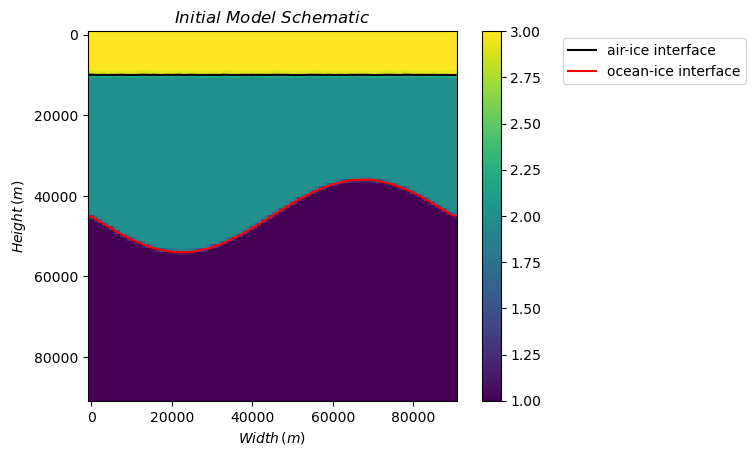

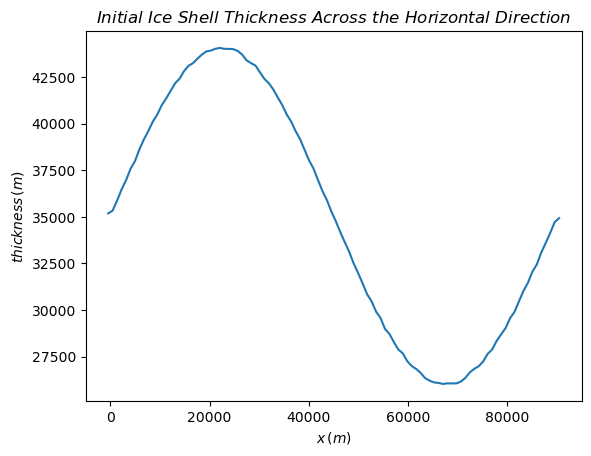

In [8]:
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
filename = "Initial Model Schematic"
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
# savefig(mk_output_dir()*"/$filename.pdf")

figure() 
plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")


println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")



# Model Schematic After x Runs 

In [ ]:
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
ocean_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

x_time = @sprintf("%.3g",time/3.15e7/1e6)
filename = "Model Schematic after $time"
figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

figure()
plot(grid.xc,ocean_ice_interface-air_ice_interface)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.3g",amp/1000),"(km)")

# Plot of Profiles After x Runs

In [ ]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


In [ ]:
t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")


In [ ]:
# 1. Ran numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 10km, 15km, 30km, 45km, 60km
#[experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]

# 1.
# units of Myr
exp1_x_tr1 = 0.00721
exp1_x_tr2 = 0.0267
exp1_x_tr3 = 0.0277
exp1_x_tr4 = 0.0533
exp1_x_tr5 = 0.0581
exp1_x_tr6 = 0.0715
exp1_x_tr7 = 0.0885


# units of km 
exp1_y_w1 = 10
exp1_y_w2 = 90
exp1_y_w3 = 100
exp1_y_w4 = 200
exp1_y_w5 = 300
exp1_y_w6 = 400
exp1_y_w7 = 500

figure()
plot(exp1_x_tr1,exp1_y_w1,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp1_x_tr2,exp1_y_w2,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp1_x_tr3,exp1_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp1_x_tr4,exp1_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp1_x_tr5,exp1_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp1_x_tr6,exp1_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp1_x_tr7,exp1_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,1")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


# 2. 
# units of Myr 
exp2_x_tr1 = 0.00939
exp2_x_tr2 = 0.0127
exp2_x_tr3 = 0.013
exp2_x_tr4 = 0.0195
exp2_x_tr5 = 0.0256
exp2_x_tr6 = 0.0323
exp2_x_tr7 = 0.04

# units of km 
exp2_y_w1 = 10
exp2_y_w2 = 90
exp2_y_w3 = 100
exp2_y_w4 = 200
exp2_y_w5 = 300
exp2_y_w6 = 400
exp2_y_w7 = 500

figure()
plot(exp2_x_tr1,exp2_y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp2_x_tr2,exp2_y_w2,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp2_x_tr3,exp2_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp2_x_tr4,exp2_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp2_x_tr5,exp2_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp2_x_tr6,exp2_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp2_x_tr7,exp2_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,2")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Printing Values 

In [ ]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)